In [1]:
import json
import os
import pandas as pd
import numpy as np
import prettytable as pt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import dates
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")


###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################


directory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
datadirectory=directory+"/data/yielddata.csv"


yielddata = pd.read_csv(datadirectory)
yielddata = yielddata.replace(np.nan, '', regex=True) 

mdirectory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
mdatadirectory=mdirectory+"/data/marketdata.csv"

marketdata = pd.read_csv(mdatadirectory)
marketdata = marketdata.replace(np.nan, '', regex=True) 


/opt/homebrew/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
FRNDefinition={}
FRNDefinition["issueDate"]="2015-07-15"
FRNDefinition["maturityDate"]="2026-06-04"
FRNDefinition["frequency"]="Quarterly"
FRNDefinition["spread"]=0.0
FRNDefinition["calendar"]="Turkey"
FRNDefinition["currency"]="TRY"
FRNDefinition["dateGeneration"]="Backward"
FRNDefinition["dayCounter"]="Actual360"
FRNDefinition["businessDayConvention"]="ModifiedFollowing"
FRNDefinition["maturityDateConvention"]="ModifiedFollowing"
FRNDefinition["redemption"]=100
FRNDefinition["endOfMonth"]=True
FRNDefinition["fixingDate"]=["2020-12-02"]
FRNDefinition["fixingRate"]=[0.0012428641149285805]
FRNDefinition

{'issueDate': '2015-07-15',
 'maturityDate': '2026-06-04',
 'frequency': 'Quarterly',
 'spread': 0.0,
 'calendar': 'Turkey',
 'currency': 'TRY',
 'dateGeneration': 'Backward',
 'dayCounter': 'Actual360',
 'businessDayConvention': 'ModifiedFollowing',
 'maturityDateConvention': 'ModifiedFollowing',
 'redemption': 100,
 'endOfMonth': True,
 'fixingDate': ['2020-12-02'],
 'fixingRate': [0.0012428641149285805]}

In [3]:
instruments={}
depo={}
irs={}

depo["businessDayConvention"]="Following"     # if it is null, default value is used
depo["dayCounter"]="Actual360"                # if it is null, default value is used

irs["businessDayConvention"]="Following"      # if it is null, default value is used 
irs["dayCounter"]="Actual360"                 # if it is null, default value is used 
irs["frequency"]="Semiannual"               

instruments["DEPO"]=depo
instruments["IRS"]=irs

instruments

{'DEPO': {'businessDayConvention': 'Following', 'dayCounter': 'Actual360'},
 'IRS': {'businessDayConvention': 'Following',
  'dayCounter': 'Actual360',
  'frequency': 'Semiannual'}}

In [4]:
# Fix parameters for building yield curve
yieldcurveconfig={
      "name": "TRYZC",
      "settlementDays": 2,
      "intpMethod": "LINEAR",
      "currency": "TRY",
      "calendar": "Turkey",
      "dayCounter": "Actual360",
      "period": "6M",
      "instruments": instruments

    }
yieldcurveconfig

{'name': 'TRYZC',
 'settlementDays': 2,
 'intpMethod': 'LINEAR',
 'currency': 'TRY',
 'calendar': 'Turkey',
 'dayCounter': 'Actual360',
 'period': '6M',
 'instruments': {'DEPO': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360'},
  'IRS': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360',
   'frequency': 'Semiannual'}}}

In [5]:
riskdata = {
  "id": "PORTFOLIO1",
  "name": "PORTFOLIO 1",
  "method": "VaR",
  "forRisk": True,
  "valuationDate": "2021-01-28",
  "valuationCurrency": "TRY",
  "riskMethod": "DELTANORMAL",
  "horizon": 252,
  "confidenceInterval": 0.99,
  "returnType": None,
  "trend": False,
  "calendar": "Turkey",
  "timeBucket": ["0D","1D","1W","2W","3W","1M","2M","3M","6M","9M","1Y","2Y","3Y","4Y",
                "5Y","6Y","7Y","8Y","9Y","10Y","12Y","15Y","20Y","25Y","30Y","40Y","50Y"],
  "fillNa": "BACKWARD",
  "maxFillNaDays": 5,
  "tasks": [
            {
      "trade_id": "FLOAT1000",
      "calculation_type": "floating_rate_bond",
      "notional": 1000000,
      "settlementDate": "2021-02-01",
      "buySell": "Buy",
      "discountCurve": "TRYZC",
      "floatingBondDefinition": FRNDefinition
    }
  ],
  "curves": [yieldcurveconfig],
  "yieldData": yielddata.to_dict('r'),
  "marketData":marketdata.to_dict('r'),
}

In [6]:
try:
    res = api.createTask(CalculationType.PORTFOLIO, riskdata, True)
    if(res["result"]):
      result=json.loads(res["result"])
    else:
      print(res["result"])
except RhoovaError as e:
    e.printPretty()

In [7]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['VAR', result.get('VaR')])
npvTable.add_row(['VAR/PV (%)', result.get('var/pv')])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)


+------------+--------------+
| Parameters |        Value |
+------------+--------------+
|         PV | 1000203.5307 |
|        VAR |      13.0053 |
| VAR/PV (%) |       0.0013 |
+------------+--------------+


In [8]:
cashflowForVar=result.get("cashflowForVar")
cashflowForVar=pd.DataFrame(cashflowForVar.get("TRYZC"))

In [9]:
frn=cashflowForVar[['fixingDate', 'accrualStart', 'accrualEnd', 'notional', 'currency',
       'leg', 'payOrReceive', 'instrument', 'rate', 'zeroRate','spread','termToMatByDay', 
        'termToMatByYear', 'cashflow', 'discountFactor','cashflowPv']]
frn

,fixingDate,accrualStart,accrualEnd,notional,currency,leg,payOrReceive,instrument,rate,zeroRate,spread,termToMatByDay,termToMatByYear,cashflow,discountFactor,cashflowPv
0,2020-12-02,2020-12-04,2021-03-04,1000000,TRY,Floating,Buy,Floating Rate Bond,0.001243,0.001244,0,31,0.086111,1.000311e+06,0.999893,1.000204e+06


In [10]:
cashflowForVar[['binLTimeToMatByDay', 'binRTimeToMatByDay', 'binL','binR', 'stDevL', 'stDevR', 'correl',
                'vertixL', 'vertixR','splitFactor', 'yieldsL', 'yieldsR', 'yields','stdev', 'duration',
                'cashflows0', 'cashflowsL', 'cashflowsR', 'presentValue', 'splitPv','splitDuration']]

,binLTimeToMatByDay,binRTimeToMatByDay,binL,binR,stDevL,stDevR,correl,vertixL,vertixR,splitFactor,...,yieldsR,yields,stdev,duration,cashflows0,cashflowsL,cashflowsR,presentValue,splitPv,splitDuration
0,21,32,3W,1M,0.053799,0.053799,1.0,TRYZC3W,TRYZC1M,0,...,0.001208,0.001208,0.053799,-86128.907848,-107165.000548,0,1.107476e+06,1.000207e+06,1.000207e+06,-86128.907848


In [11]:
mappedcf=cashflowForVar[['termToMatByDay','cashflow',"binLTimeToMatByDay","binRTimeToMatByDay",'cashflows0', 'cashflowsL', 'cashflowsR', 'presentValue', 'splitPv',"duration",'splitDuration']]
mappedcf

,termToMatByDay,cashflow,binLTimeToMatByDay,binRTimeToMatByDay,cashflows0,cashflowsL,cashflowsR,presentValue,splitPv,duration,splitDuration
0,31,1.000311e+06,21,32,-107165.000548,0,1.107476e+06,1.000207e+06,1.000207e+06,-86128.907848,-86128.907848


In [12]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['Split PV', cashflowForVar["splitPv"].sum()])
npvTable.add_row(['Errror', 100*(result.get('pv')-cashflowForVar["splitPv"].sum())/result.get('pv')])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)
print("PV is preserved")

+------------+--------------+
| Parameters |        Value |
+------------+--------------+
|         PV | 1000203.5307 |
|   Split PV | 1000206.6718 |
|     Errror |      -0.0003 |
+------------+--------------+
PV is preserved


In [13]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['Duration', cashflowForVar["duration"].sum()])
npvTable.add_row(['Split Duration', cashflowForVar["splitDuration"].sum()])
npvTable.add_row(['Errror', 100*(cashflowForVar["duration"].sum()-cashflowForVar["splitDuration"].sum())/cashflowForVar["duration"].sum()])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)
print("Duration is preserved")

+----------------+-------------+
|     Parameters |       Value |
+----------------+-------------+
|       Duration | -86128.9078 |
| Split Duration | -86128.9078 |
|         Errror |     -0.0000 |
+----------------+-------------+
Duration is preserved


In [14]:
original_cf=pd.DataFrame(cashflowForVar['cashflow'].values,index=cashflowForVar['termToMatByDay'].tolist()).reset_index()
original_cf.columns=["bin","cashflows"]
original_cf=original_cf.groupby('bin').sum()
original_cf=original_cf.reset_index()


In [15]:
leftcf=cashflowForVar[["binLTimeToMatByDay","cashflowsL"]]
leftcf.columns=["bin","cashflows"]
rightcf=cashflowForVar[["binRTimeToMatByDay","cashflowsR"]]
rightcf.columns=["bin","cashflows"]
mappedcf=pd.concat([leftcf,rightcf])
mappedcf=mappedcf.groupby('bin').sum()
mappedcf=mappedcf.reset_index()


In [16]:
mappedcf0=cashflowForVar["cashflows0"].sum()
mappedcf["Cashflows"]="mapped cashflows"
original_cf["Cashflows"]="original cashflows"
cf=pd.concat([original_cf,mappedcf])
cf.loc[len(cf.index)] = [0,mappedcf0,"mapped cashflows0"] 
cf

,bin,cashflows,Cashflows
0,31,1.000311e+06,original cashflows
0,21,0.000000e+00,mapped cashflows
1,32,1.107476e+06,mapped cashflows
3,0,-1.071650e+05,mapped cashflows0


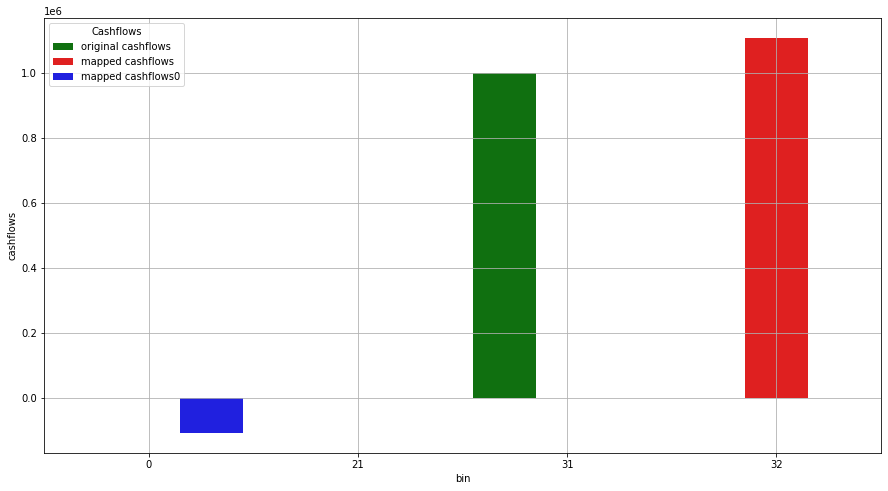

In [17]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x="bin",y="cashflows",data=cf,hue="Cashflows",width=0.9,palette=["green", "red","blue"])
ax.grid()

In [19]:
portfoliocorr=result.get("riskFactorsCorr")
pd.DataFrame(portfoliocorr)

,TRYZC0D,TRYZC1D,TRYZC1W,TRYZC2W,TRYZC3W,TRYZC1M,TRYZC2M,TRYZC3M,TRYZC6M,TRYZC9M,...,TRYZC8Y,TRYZC9Y,TRYZC10Y,TRYZC12Y,TRYZC15Y,TRYZC20Y,TRYZC25Y,TRYZC30Y,TRYZC40Y,TRYZC50Y
TRYZC0D,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.691755,0.563094,0.503333,0.543372,...,0.195936,0.204695,0.255008,0.261205,0.238894,0.246247,0.234173,0.290357,0.267326,0.234319
TRYZC1D,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.691755,0.563094,0.503333,0.543372,...,0.195936,0.204695,0.255008,0.261205,0.238894,0.246247,0.234173,0.290357,0.267326,0.234319
TRYZC1W,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.691755,0.563094,0.503333,0.543372,...,0.195936,0.204695,0.255008,0.261205,0.238894,0.246247,0.234173,0.290357,0.267326,0.234319
TRYZC2W,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.691755,0.563094,0.503333,0.543372,...,0.195936,0.204695,0.255008,0.261205,0.238894,0.246247,0.234173,0.290357,0.267326,0.234319
TRYZC3W,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.691755,0.563094,0.503333,0.543372,...,0.195936,0.204695,0.255008,0.261205,0.238894,0.246247,0.234173,0.290357,0.267326,0.234319
TRYZC1M,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.691755,0.563094,0.503333,0.543372,...,0.195936,0.204695,0.255008,0.261205,0.238894,0.246247,0.234173,0.290357,0.267326,0.234319
TRYZC2M,0.691755,0.691755,0.691755,0.691755,0.691755,0.691755,1.000000,0.661129,0.546814,0.606043,...,0.213672,0.226003,0.253081,0.248765,0.242510,0.259471,0.247552,0.291342,0.253118,0.215198
TRYZC3M,0.563094,0.563094,0.563094,0.563094,0.563094,0.563094,0.661129,1.000000,0.596626,0.630402,...,0.128450,0.141817,0.152673,0.158080,0.155367,0.170653,0.167664,0.193558,0.170175,0.148219
TRYZC6M,0.503333,0.503333,0.503333,0.503333,0.503333,0.503333,0.546814,0.596626,1.000000,0.923736,...,0.158446,0.179902,0.227436,0.197655,0.208182,0.228275,0.219192,0.268292,0.250160,0.222918
TRYZC9M,0.543372,0.543372,0.543372,0.543372,0.543372,0.543372,0.606043,0.630402,0.923736,1.000000,...,0.166485,0.193191,0.232536,0.204874,0.228971,0.250858,0.241200,0.289878,0.262963,0.230464


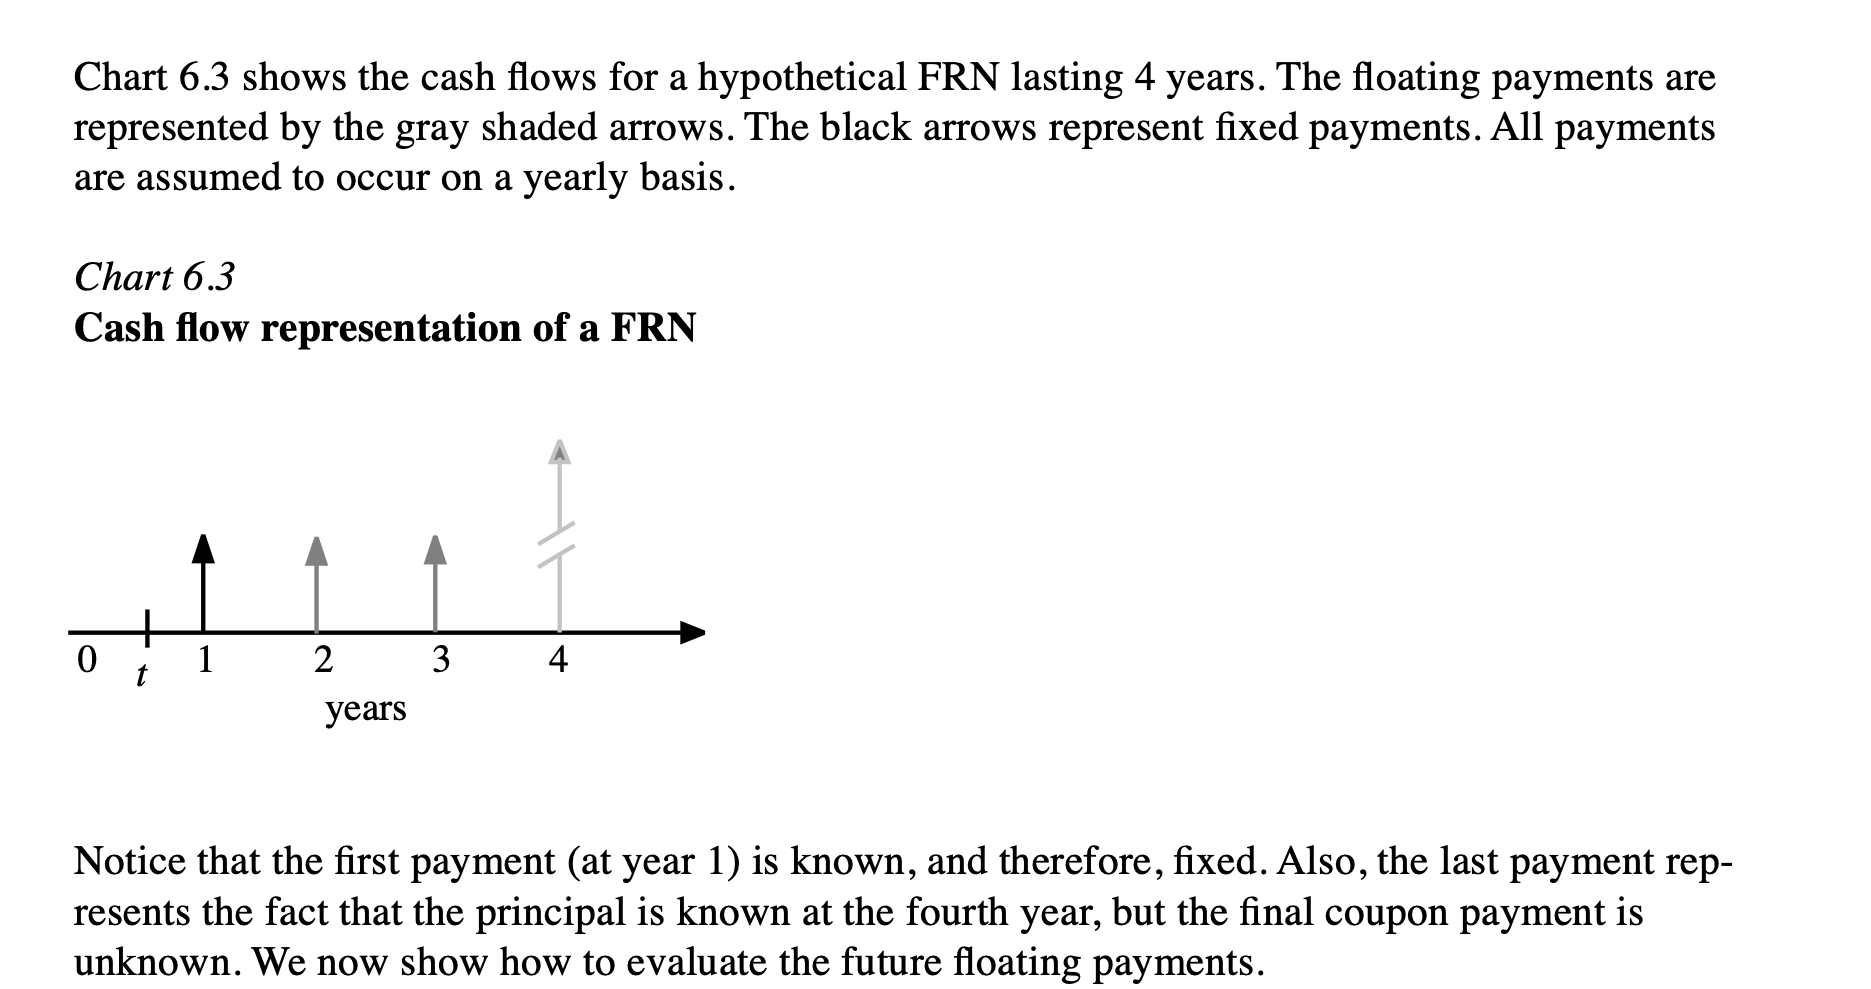

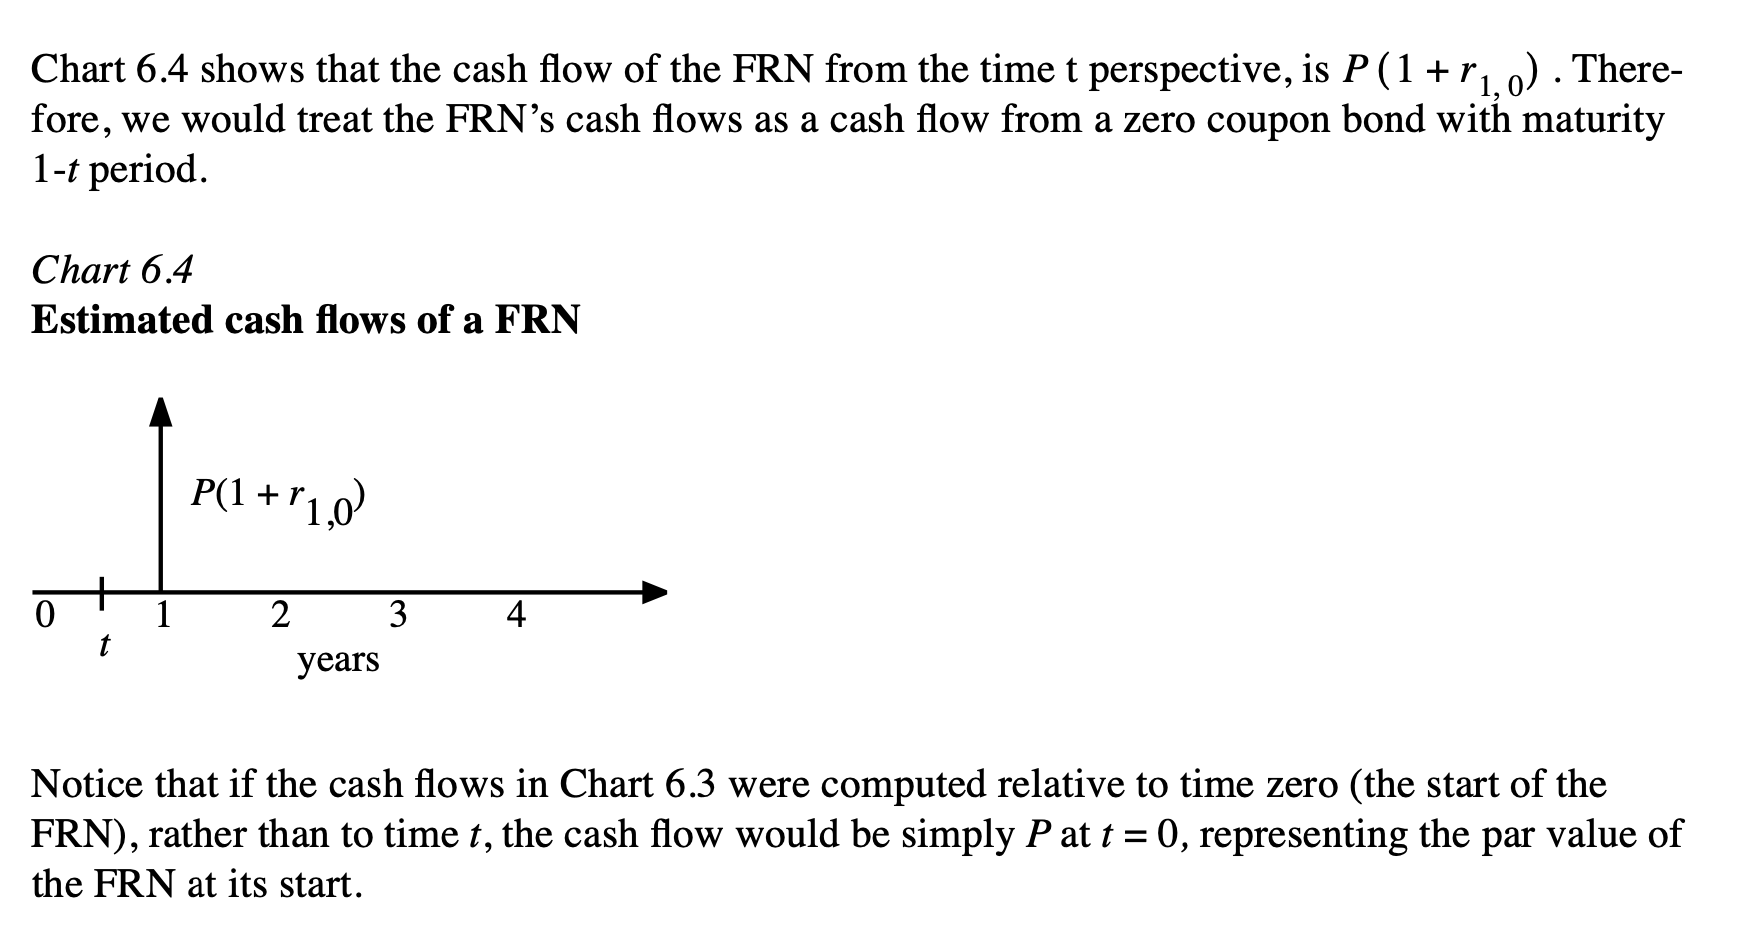

In [ ]:
# https://www.msci.com/documents/10199/5915b101-4206-4ba0-aee2-3449d5c7e95a (Page 110)